In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df=pd.read_csv("/content/drive/MyDrive/Crimes_2001_to_Present.csv")

In [5]:
df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [6]:
# drop the "faulty" years

df=df[df.Year > 2002]

In [7]:
df.drop(columns=['Case Number', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'], inplace=True)

**Crimes per community area (ca)**:


In [8]:
ca_df=df.groupby("Community Area").count()[["ID"]].rename(columns={"ID" : "crime_count" })
ca_df

crime_count
Community Area             
0.0                      70
1.0                  110718
2.0                   92908
3.0                  105113
4.0                   51475
...                     ...
73.0                  85608
74.0                  15979
75.0                  57005
76.0                  41798
77.0                  72641

[78 rows x 1 columns]

**Daily crimes in ca 25**:

In [9]:
worst =  float(ca_df[ ca_df["crime_count"]==int(ca_df.max()[0]) ].index[0] )
df_25=df[df["Community Area"]==worst].drop(columns="Community Area")

<ipython-input-9-51a5dc798c83>:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  worst =  float(ca_df[ ca_df["crime_count"]==int(ca_df.max()[0]) ].index[0] )


In [10]:
# convert date to datetime

from datetime import datetime

def timer(t):
    return datetime.strptime(t, "%m/%d/%Y %I:%M:%S %p")

df_25["Date_dt"]=df_25["Date"].apply(timer)

In [11]:
df_25["day"]=df_25['Date_dt'].dt.to_period('D')

In [12]:
ca25daily_df=df_25.groupby("day").count().rename(columns={"ID" : "crime_count" })[["crime_count"]]

In [13]:
ca25daily_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 7894 entries, 2003-01-01 to 2024-08-11
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   crime_count  7894 non-null   int64
dtypes: int64(1)
memory usage: 123.3 KB


<Axes: xlabel='day'>

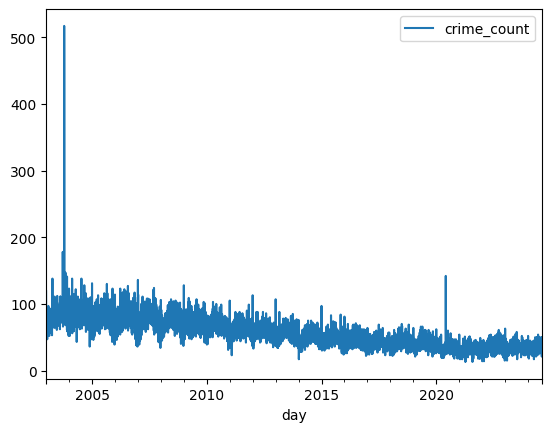

In [14]:
ca25daily_df.plot()

In [145]:
ca25daily_df.head(100)

crime_count
day                    
2003-01-01          119
2003-01-02           73
2003-01-03           91
2003-01-04           73
2003-01-05           80
...                 ...
2003-04-06           83
2003-04-07           72
2003-04-08           93
2003-04-09           90
2003-04-10           81

[100 rows x 1 columns]

**NN model:**

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [16]:
# DATA PREPROCESS

# turn crimes into list
crime_count_list = list(ca25daily_df["crime_count"])

# parameters
sequence_length = 366  # number of days to consider for predicting the next day

# create sequences
X, y = [], []
for i in range(sequence_length, len(crime_count_list)):
    X.append(crime_count_list[i-sequence_length:i])
    y.append(crime_count_list[i])

X = np.array(X)
y = np.array(y)

# train_test_split
train_size = int(len(X) * 0.8)  # 80% for training
X_train_full, X_test, y_train_full, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

In [17]:
scaler=MinMaxScaler()

scaler.fit(X_train)

MinMaxScaler()

In [18]:
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_val_scaled=scaler.transform(X_val)

In [21]:
# NN Architecture:

model = Sequential()

model.add(layers.Conv1D( filters=64, kernel_size=52, input_shape=(366, 1) ) )
#model.add(Dropout(0.1))

model.add(layers.GRU(units=64, activation='relu'
                     #, return_sequences=True
                    ))
#model.add(Dropout(0.2))

#model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

# 2- Compilation
model.compile(loss='mae',
              optimizer=Adam(learning_rate=0.001))

# 3- Fit
#es = EarlyStopping(patience=0, restore_best_weights=True)

history=model.fit(X_train_scaled, y_train, epochs=10, verbose=1, batch_size= 16 ,validation_data=(X_val_scaled,y_val)
                  #, callbacks=[es]
                 )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 24s 73ms/step - loss: 26.9041 - val_loss: 6.9134
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 38s 67ms/step - loss: 8.8864 - val_loss: 6.4337
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 8.8224 - val_loss: 6.4108
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 8.6128 - val_loss: 6.5696
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - loss: 8.9064 - val_loss: 6.5282
Epoch 6/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 8.7228 - val_loss: 6.6771
Epoch 7/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - loss: 8.5264 - val_loss: 6.4407
Epoch 8/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 8.2395 - val_loss: 6.2673
Epoch 9/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 8.4968 - val_loss: 6.4412
Epoch 10/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - loss: 8.4071 - val_loss: 6.2361


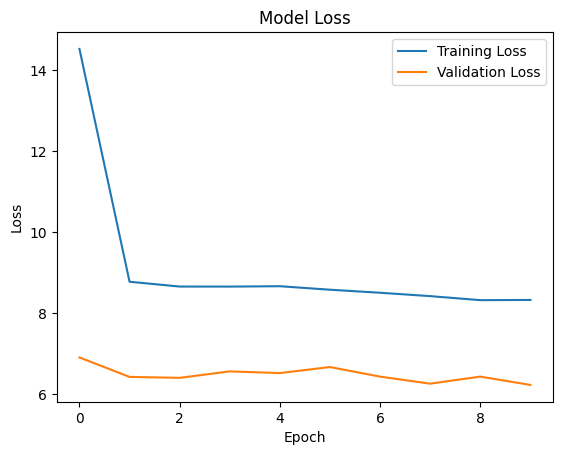

In [22]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [25]:
# 4- Predict
y_pred=model.predict(X_test_scaled)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


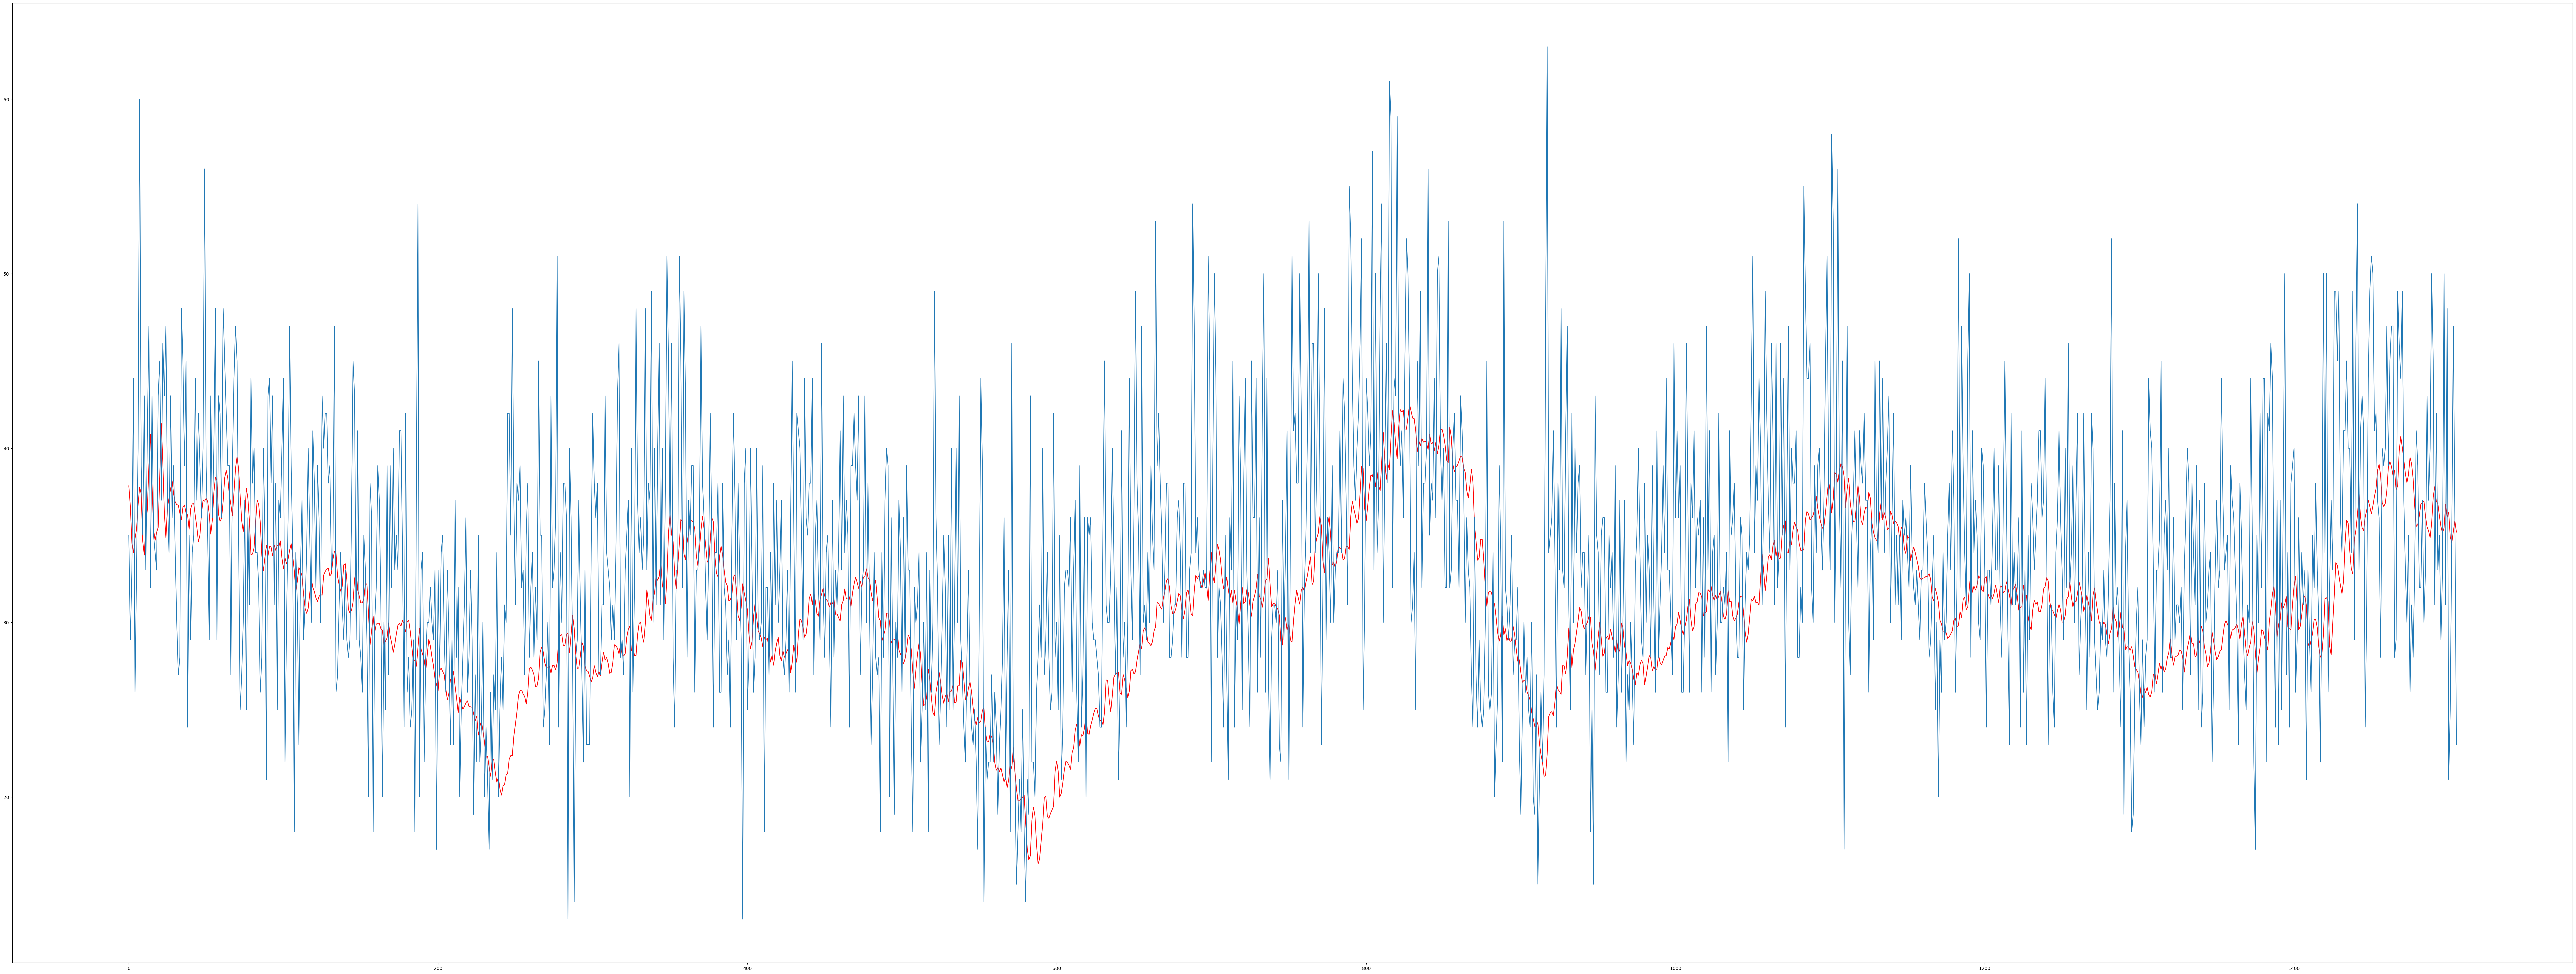

In [26]:
plt.axes([0,0,12,6])
plt.plot(pd.DataFrame(y_pred), color= "red")
plt.plot(pd.DataFrame(y_test))
plt.show()

**Now add weather data:**

In [118]:
w25df=pd.read_csv("/content/drive/MyDrive/weather_tps_25.csv")

In [119]:
w25df.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

In [120]:
weather25_df=wdf.drop(columns=['name', 'tempmax', 'tempmin', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precipprob',
       'precipcover', 'preciptype', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'])

In [121]:
def to_dt(t):
    return datetime.strptime(t, "%Y-%m-%d")

weather25_df["dt"]=weather25_df["datetime"].apply(to_dt)

In [122]:
weather25_df=weather25_df[ weather25_df["dt"].dt.year > 2002 ]

In [123]:
weather25_df["day"]=weather25_df[ weather25_df["dt"].dt.year > 2002]['dt'].dt.to_period('D')

<ipython-input-123-1f69f1268145>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather25_df["day"]=weather25_df[ weather25_df["dt"].dt.year > 2002]['dt'].dt.to_period('D')


In [124]:
weather25_df.drop(columns=["datetime","dt"], inplace=True)

In [125]:
weather25_df.sort_values("day", inplace=True)

In [126]:
weather25_df=weather25_df[:-1].set_index("day")

In [127]:
weather25_df

temp  precip  snow
day                           
2003-01-01  -0.6   0.000   0.0
2003-01-02  -1.6   0.300   0.0
2003-01-03  -1.9   0.000   0.0
2003-01-04  -2.9   1.126   0.0
2003-01-05  -0.3   1.297   0.0
...          ...     ...   ...
2024-08-07  22.7   0.000   0.0
2024-08-08  23.7   0.000   0.0
2024-08-09  20.1   0.000   0.0
2024-08-10  19.5   0.000   0.0
2024-08-11  21.0   0.000   0.0

[7894 rows x 3 columns]

In [128]:
# combine weather and crime into one df:

comb25_df= ca25daily_df.join(weather25_df)
comb25_df

crime_count  temp  precip  snow
day                                        
2003-01-01          119  -0.6   0.000   0.0
2003-01-02           73  -1.6   0.300   0.0
2003-01-03           91  -1.9   0.000   0.0
2003-01-04           73  -2.9   1.126   0.0
2003-01-05           80  -0.3   1.297   0.0
...                 ...   ...     ...   ...
2024-08-07           25  22.7   0.000   0.0
2024-08-08           35  23.7   0.000   0.0
2024-08-09           47  20.1   0.000   0.0
2024-08-10           36  19.5   0.000   0.0
2024-08-11           23  21.0   0.000   0.0

[7894 rows x 4 columns]

In [129]:
# generate data:

crime_count_list = list(comb25_df["crime_count"])
new_feature_list = list(comb25_df["temp"])


# Parameters
sequence_length = 366  # Number of days to consider for predicting the next day

# Create sequences
X, y = [], []
for i in range(sequence_length, len(crime_count_list)):
    # Create a sequence of [crime_count, new_feature]
    sequence = np.column_stack((crime_count_list[i-sequence_length:i],
                                new_feature_list[i-sequence_length:i]))
    X.append(sequence)
    y.append(crime_count_list[i])  # Target is still the crime count

X = np.array(X)
y = np.array(y)

# Now X has shape (samples, timesteps, features), e.g., (n_samples, 366, 2)

# Train-test split
train_size = int(len(X) * 0.8)  # 80% for training
X_train_full, X_test, y_train_full, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=False)

# X_train, X_val, X_test will all have shape (samples, timesteps, features)

In [136]:
# Scaling:

crime_scaler = MinMaxScaler()
temp_scaler = StandardScaler()

# Reshape to 2D for scaling
X_train_crime = X_train[:, :, 0].reshape(-1, 1)
X_train_temp = X_train[:, :, 1].reshape(-1, 1)

# Fit the scalers on the training data
crime_scaler.fit(X_train_crime)
temp_scaler.fit(X_train_temp)

# Transform the training data
X_train[:, :, 0] = crime_scaler.transform(X_train_crime).reshape(X_train[:, :, 0].shape)
X_train[:, :, 1] = temp_scaler.transform(X_train_temp).reshape(X_train[:, :, 1].shape)

# Transform the validation data
X_val[:, :, 0] = crime_scaler.transform(X_val[:, :, 0].reshape(-1, 1)).reshape(X_val[:, :, 0].shape)
X_val[:, :, 1] = temp_scaler.transform(X_val[:, :, 1].reshape(-1, 1)).reshape(X_val[:, :, 1].shape)

# Transform the test data
X_test[:, :, 0] = crime_scaler.transform(X_test[:, :, 0].reshape(-1, 1)).reshape(X_test[:, :, 0].shape)
X_test[:, :, 1] = temp_scaler.transform(X_test[:, :, 1].reshape(-1, 1)).reshape(X_test[:, :, 1].shape)

# Don't forget to scale the target variable (crime count) as well
y_train = crime_scaler.transform(y_train.reshape(-1, 1)).flatten()
y_val = crime_scaler.transform(y_val.reshape(-1, 1)).flatten()
y_test = crime_scaler.transform(y_test.reshape(-1, 1)).flatten()

# Now X_train, X_val, X_test, y_train, y_val, y_test are all scaled properly

In [139]:
# NN Architecture:

model = Sequential()

model.add(layers.Conv1D( filters=64, kernel_size=52, input_shape=(366, 2) ) )
#model.add(Dropout(0.1))

model.add(layers.GRU(units=64, activation='relu'
                     #, return_sequences=True
                    ))
#model.add(Dropout(0.2))

#model.add(layers.Dense(20, activation="relu"))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="linear"))

# 2- Compilation
model.compile(loss='mae',
              optimizer=Adam(learning_rate=0.001))

# 3- Fit
#es = EarlyStopping(patience=0, restore_best_weights=True)

history=model.fit(X_train, y_train, epochs=23, verbose=1, batch_size= 16 ,validation_data=(X_val,y_val)
                  #, callbacks=[es]
                 )

Epoch 1/23
283/283 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - loss: 0.0313 - val_loss: 0.0172
Epoch 2/23
283/283 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - loss: 0.0192 - val_loss: 0.0138
Epoch 3/23
283/283 ━━━━━━━━━━━━━━━━━━━━ 19s 66ms/step - loss: 0.0196 - val_loss: 0.0160
Epoch 4/23
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - loss: 0.0179 - val_loss: 0.0137
Epoch 5/23
283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 0.0172 - val_loss: 0.0127
Epoch 6/23
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - loss: 0.0177 - val_loss: 0.0129
Epoch 7/23
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - loss: 0.0173 - val_loss: 0.0137
Epoch 8/23
283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 68ms/step - loss: 0.0172 - val_loss: 0.0126
Epoch 9/23
283/283 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - loss: 0.0164 - val_loss: 0.0127
Epoch 10/23
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - loss: 0.0171 - val_loss: 0.0146
Epoch 11/23
283/283 ━━━━━━━━━━━━━━━━━━━━ 21s 69ms/step - loss: 0.0173 - val_loss: 0.0134
Epoch 12/23
283/283 ━━━━━━━━━━

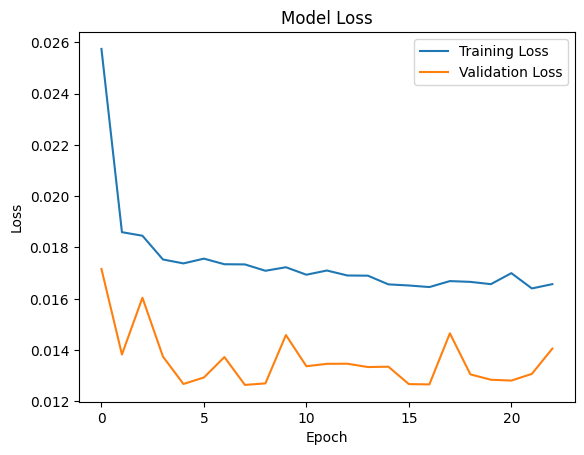

In [140]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [141]:
y_pred=model.predict(X_test)

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


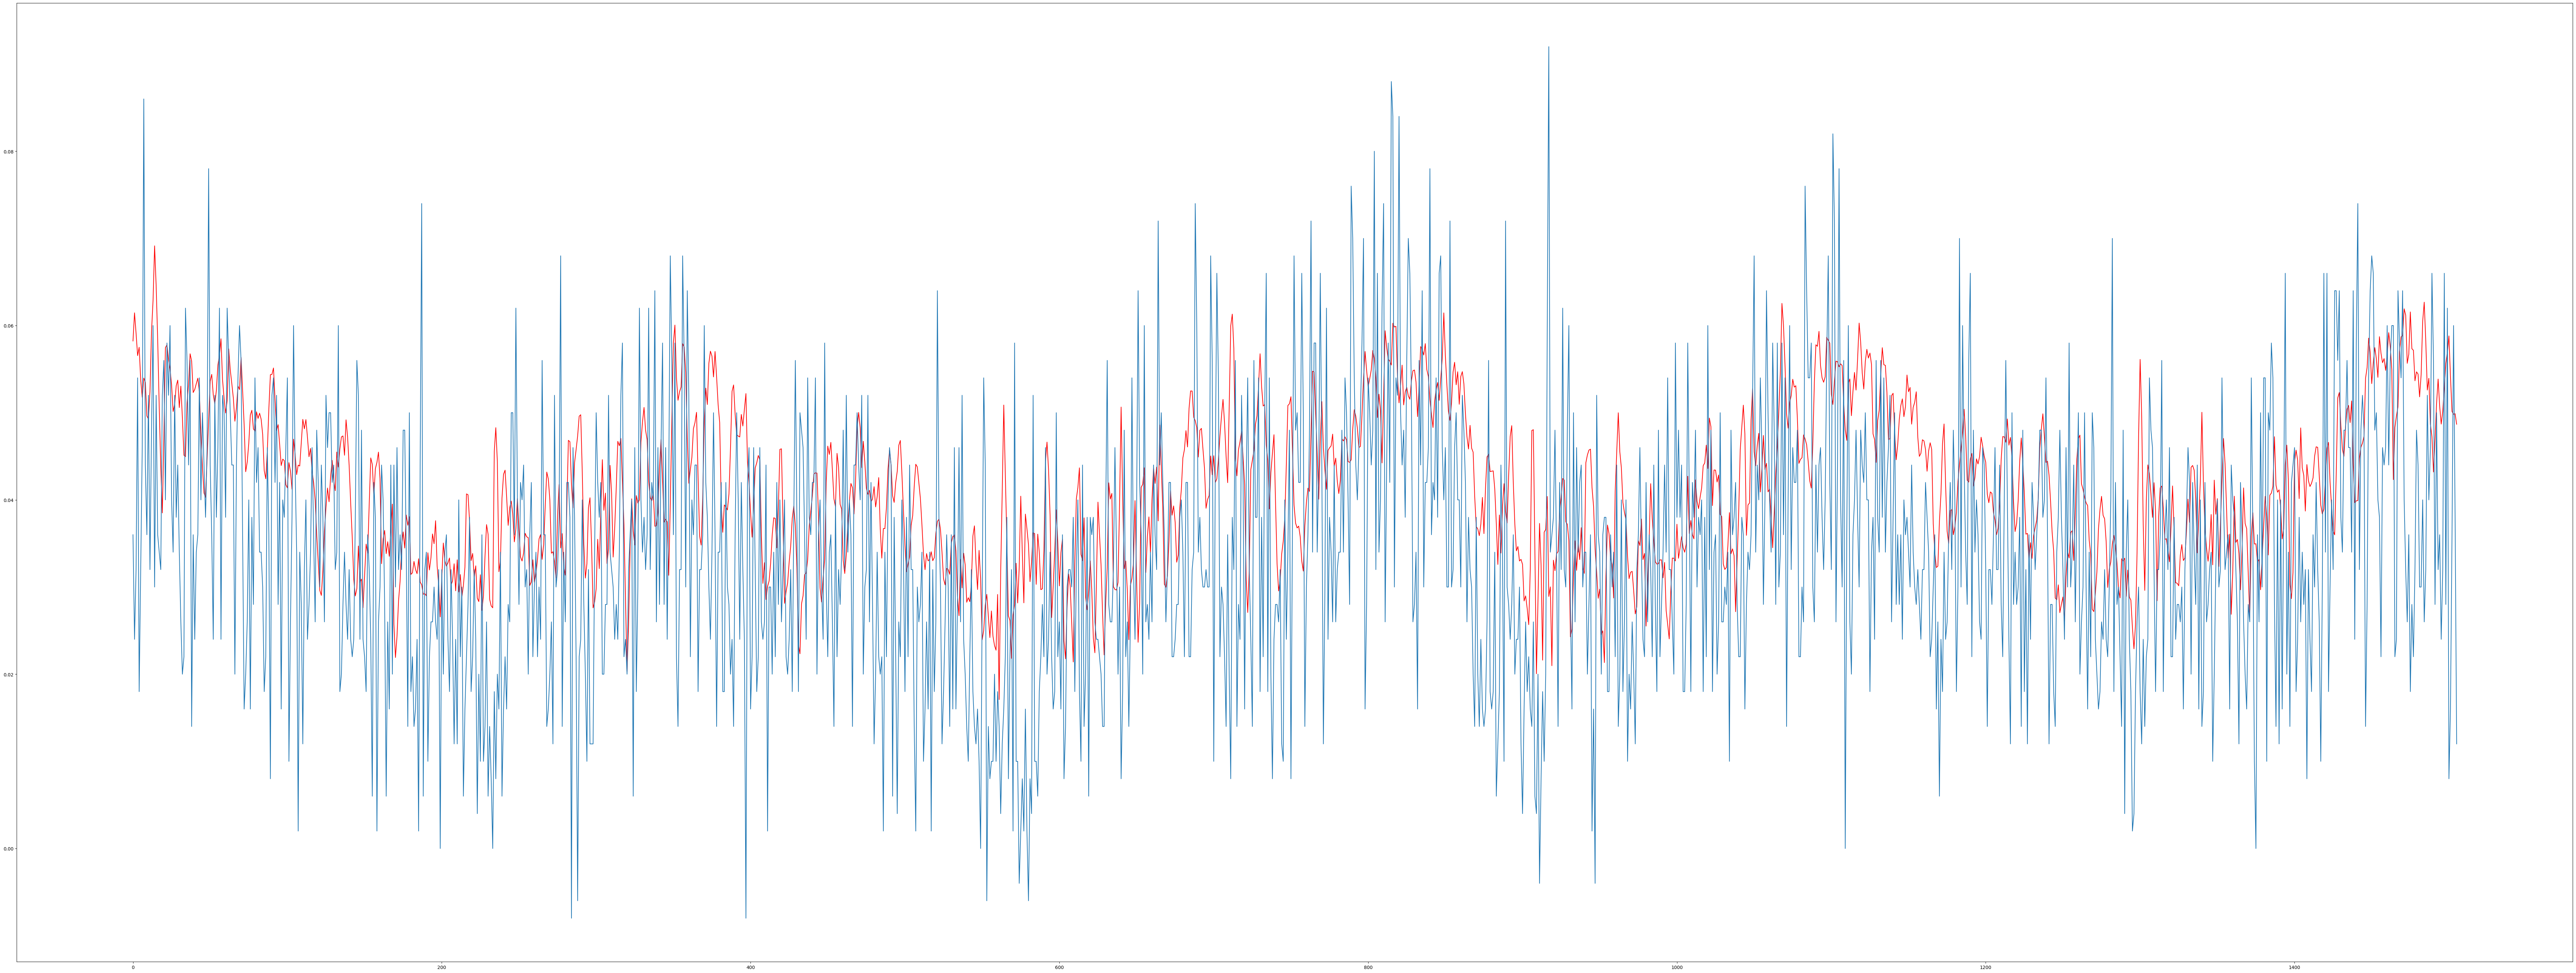

In [142]:
plt.axes([0,0,12,6])
plt.plot(pd.DataFrame(y_pred), color= "red")
plt.plot(pd.DataFrame(y_test))
plt.show()

In [143]:
history.history

{'loss': [0.025737911462783813,
  0.01859644427895546,
  0.01845822110772133,
  0.017533138394355774,
  0.01738002337515354,
  0.017565231770277023,
  0.017347801476716995,
  0.01734071969985962,
  0.017092766240239143,
  0.017230169847607613,
  0.016939040273427963,
  0.01710294932126999,
  0.016909198835492134,
  0.01690150797367096,
  0.01656288653612137,
  0.01651945151388645,
  0.01645827293395996,
  0.016690796241164207,
  0.01666031777858734,
  0.0165712833404541,
  0.016999946907162666,
  0.01640450581908226,
  0.01657175086438656],
 'val_loss': [0.017163239419460297,
  0.013830984011292458,
  0.016042077913880348,
  0.013749354518949986,
  0.01268092356622219,
  0.01293474342674017,
  0.013730928301811218,
  0.012644650414586067,
  0.012704997323453426,
  0.014588279649615288,
  0.013372992165386677,
  0.013466279953718185,
  0.013470898382365704,
  0.013341143727302551,
  0.013354835100471973,
  0.012676119804382324,
  0.012665223330259323,
  0.01465496513992548,
  0.01305543

TODO: transfer back, to get mean absolute errors...